## Challenge TelecomX-2-ML – Análisis Predictivo de Churn

### Objetivo

En esta segunda etapa del Challenge de Data Science de Alura, el enfoque se centra en el **modelado predictivo** para anticipar la evasión de clientes (Churn) en TelecomX.
Luego de completar el proceso de **ETL y Análisis Exploratorio (EDA)**, el objetivo ahora es construir, evaluar y optimizar modelos de Machine Learning que permitan:

* Predecir qué clientes tienen mayor probabilidad de abandonar el servicio.
* Identificar las variables más influyentes en la decisión de churn.
* Proporcionar recomendaciones estratégicas basadas en evidencia predictiva.


Flujo de implementación:

1. Limpieza
2. Feature Engineering
3. Análisis categórico y test Chi²
4. Preprocesamiento
5. Train/Test SplitPipeline
6. Cross-Validation (en Train)
7. Comparación de modelos
8. Optimización
9. Entrenamiento final
10. Evaluación en Test

---



## Implementación del Modelado Predictivo


### Importación de librerías y configuración del entorno

In [13]:
# ==============================
# CONFIGURACIÓN GLOBAL
# ==============================

# Ignorar warnings irrelevantes
import warnings
#warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


# ==============================
# BIBLIOTECAS PARA MANEJO DE DATOS
# ==============================

import requests
import pandas as pd
import numpy as np
import json
import os

# ==============================
# BIBLIOTECAS PARA PREPROCESAMIENTO - ML
# ==============================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
# ==============================
# BIBLIOTECAS PARA VISUALIZACIÓN
# ==============================

import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# CONFIGURACIÓN DE VISUALIZACIONES
# ==============================

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Si trabajas en Jupyter, puedes activar esto:
# %matplotlib inline

# ==============================
# CONFIGURACIÓN DE PANDAS
# ==============================

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# ==============================
# PALETA DE COLORES PERSONALIZADA
# ==============================

color_no_churn = '#2C3E50'  # Azul oscuro elegante
color_churn = '#E74C3C'     # Rojo elegante

color_palette = [
  '#F8F9FA', # Fondo Limpio (Ghost White)
  '#E9ECEF', # Bordes/Secciones (Slate Gray)
  '#22577A', # Títulos/Estructura (Dark Imperial Blue)
  '#38A3A5', # Procesos activos (Cadet Blue)
  '#57CC99', # Éxito/Validación (Emerald)
  '#80ED99'  # Acentos ligeros (Light Green)
]

sns.set_palette(color_palette)

# ==============================
# CREAR CARPETA PARA IMÁGENES
# ==============================

os.makedirs('imgs', exist_ok=True)

print('✅ Bibliotecas importadas y entorno configurado correctamente')

✅ Bibliotecas importadas y entorno configurado correctamente


### Carga de datos

Previo análisis con dataset generado en la 1ra etapa y al no encontrar mayores inconsistencias, se utiliza el dataset proprocionado por Alura One "dataset_tratado.csv". 

In [14]:
url = "https://raw.githubusercontent.com/LenninTemoche/Challenge-TelecomX-2-Alura-One-DS/refs/heads/main/datos_tratados.csv"

df = pd.read_csv(url, sep=",")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7043 non-null   object 
 1   Churn             7043 non-null   object 
 2   Gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   object 
 4   Partner           7043 non-null   object 
 5   Dependents        7043 non-null   object 
 6   Tenure            7043 non-null   int64  
 7   PhoneService      7043 non-null   object 
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contract          7043 non-null   object 


## 1. Limpieza de Datos

En esta etapa se garantiza la calidad del dataset antes del modelado.

Se realizaron las siguientes acciones:

- Estandarización de categorías inconsistentes.
- Eliminación de variables sin valor predictivo.
- Verificación final de valores nulos.
- Eliminación de registros duplicados (si existieran).

Este paso es fundamental para evitar ruido, sesgos y errores en el entrenamiento de los modelos.

In [15]:
import numpy as np
import pandas as pd

print("Iniciando limpieza de datos...\n")

# ============================================================
# 1 DIAGNÓSTICO INICIAL
# ============================================================

diagnostico_inicial = pd.DataFrame({
    "Métrica": [
        "Filas iniciales",
        "Columnas iniciales",
        "Nulos totales",
        "Duplicados (con ID)"
    ],
    "Valor": [
        df.shape[0],
        df.shape[1],
        df.isnull().sum().sum(),
        df.duplicated().sum()
    ]
})

display(diagnostico_inicial)


# ============================================================
# 2 ESTANDARIZACIÓN DE CATEGORÍAS
# ============================================================

cols_to_fix = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

cambios_categorias = []

for col in cols_to_fix:
    if col in df.columns:
        antes = df[col].value_counts(dropna=False)
        df[col] = df[col].replace({'No internet service': 'No'})
        despues = df[col].value_counts(dropna=False)

        cambios_categorias.append({
            "Columna": col,
            "Valores únicos antes": len(antes),
            "Valores únicos después": len(despues),
            "Cambio aplicado": "Sí"
        })

tabla_cambios = pd.DataFrame(cambios_categorias)
display(tabla_cambios)


# ============================================================
# 3 ELIMINACIÓN DE ID Y DUPLICADOS
# ============================================================

columnas_antes = df.shape[1]

if 'CustomerID' in df.columns:
    df = df.drop(columns=['CustomerID'])
    id_eliminado = "CustomerID"
elif 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])
    id_eliminado = "customerID"
else:
    id_eliminado = "No encontrado"

columnas_despues = df.shape[1]

duplicados_sin_id = df.duplicated().sum()
filas_antes = df.shape[0]

if duplicados_sin_id > 0:
    df = df.drop_duplicates()
    filas_despues = df.shape[0]
else:
    filas_despues = filas_antes

tabla_duplicados = pd.DataFrame({
    "Métrica": [
        "Columna ID eliminada",
        "Columnas antes",
        "Columnas después",
        "Duplicados encontrados",
        "Filas antes limpieza",
        "Filas después limpieza"
    ],
    "Valor": [
        id_eliminado,
        columnas_antes,
        columnas_despues,
        duplicados_sin_id,
        filas_antes,
        filas_despues
    ]
})

display(tabla_duplicados)


# ============================================================
# 4 REPORTE FINAL DE NULOS
# ============================================================

reporte_nulos = pd.DataFrame({
    'Nulos': df.isnull().sum(),
    'Porcentaje (%)': (df.isnull().sum() / len(df)) * 100
}).sort_values(by='Nulos', ascending=False)

display(reporte_nulos)

# Seleccionar variables numéricas
df_numeric = df.select_dtypes(include=["int64", "float64"]).copy()

# 5 Convertir Churn a numérico para análisis decorrelación -EDA
df_numeric["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})


# ============================================================
# 6 RESUMEN FINAL
# ============================================================

resumen_final = pd.DataFrame({

    "Métrica": [
        "Filas finales",
        "Columnas finales",
        "Nulos totales finales",
        "Duplicados totales finales"
    ],
    "Valor": [
        df.shape[0],
        df.shape[1],
        df.isnull().sum().sum(),
        df.duplicated().sum()
    ]
    
})

display(resumen_final)

print("✅ Limpieza finalizada correctamente.")

Iniciando limpieza de datos...



,Métrica,Valor
0,Filas iniciales,7043
1,Columnas iniciales,22
2,Nulos totales,0
3,Duplicados (con ID),0


,Columna,Valores únicos antes,Valores únicos después,Cambio aplicado
0,OnlineSecurity,2,2,Sí
1,OnlineBackup,2,2,Sí
2,DeviceProtection,2,2,Sí
3,TechSupport,2,2,Sí
4,StreamingTV,2,2,Sí
5,StreamingMovies,2,2,Sí


,Métrica,Valor
0,Columna ID eliminada,CustomerID
1,Columnas antes,22
2,Columnas después,21
3,Duplicados encontrados,22
4,Filas antes limpieza,7043
5,Filas después limpieza,7021


,Nulos,Porcentaje (%)
Churn,0,0.0
DeviceProtection,0,0.0
ChargesMonthly,0,0.0
ChargesDaily,0,0.0
PaymentMethod,0,0.0
PaperlessBilling,0,0.0
Contract,0,0.0
StreamingMovies,0,0.0
StreamingTV,0,0.0
TechSupport,0,0.0


,Métrica,Valor
0,Filas finales,7021
1,Columnas finales,21
2,Nulos totales finales,0
3,Duplicados totales finales,0


✅ Limpieza finalizada correctamente.


#### **Resultados clave**

- El dataset no contiene valores nulos ni registros duplicados considerando la columna identificadora.
  * Filas iniciales: 7,043
  * Columnas iniciales: 22

- Estandarización de categorías se aplicó correctamente.
  * Se reemplazó "No internet service" por "No".
  * Asegurar que "Churn" sea numérico.

- Al eliminar la columna identificadora se detectaron 22 registros duplicados reales, los cuales fueron removidos correctamente.

  * Columna ID eliminada: CustomerID
  * Columnas antes: 22
  * Columnas después: 21
  * Duplicados encontrados (sin ID): 22
  * Filas antes de eliminar duplicados: 7,043
  * Filas después de eliminar duplicados: 7,021

El dataset quedó correctamente **estructurado y consistente** para análisis posterior.

#### Análisis de correlación de variables

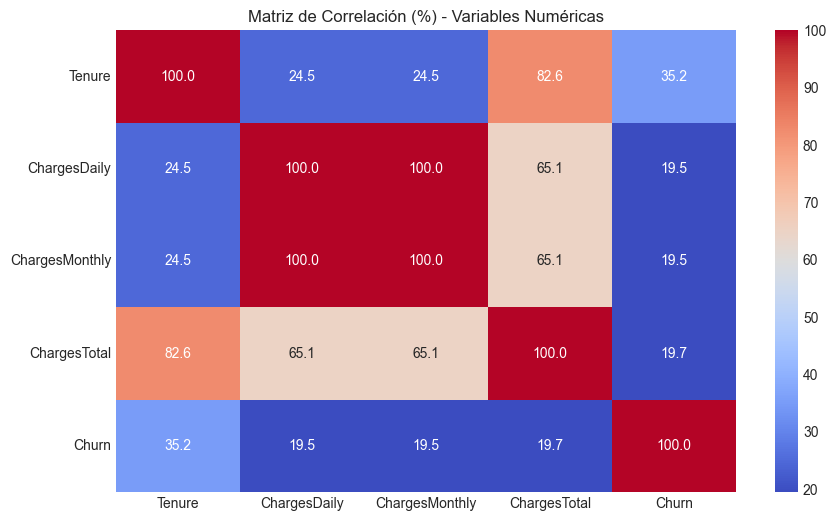


 Máximo porcentaje de correlación por variable:
ChargesDaily      99.999564
ChargesMonthly    99.999564
Tenure            82.559482
ChargesTotal      82.559482
Churn             35.150800
dtype: float64

 Porcentaje de correlación de cada variable con Churn:
Tenure            35.150800
ChargesTotal      19.719808
ChargesDaily      19.456229
ChargesMonthly    19.450774
Name: Churn, dtype: float64


In [16]:
# Matriz de correlación
corr_matrix = df_numeric.corr()

# Convertir a porcentaje absoluto
corr_percent = corr_matrix.abs() * 100

# ==============================
# 1 MATRIZ HEATMAP
# ==============================
plt.figure(figsize=(10,6))
sns.heatmap(corr_percent, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Matriz de Correlación (%) - Variables Numéricas")
plt.show()

# ==============================
# 2 PORCENTAJE MÁXIMO POR VARIABLE
# ==============================

# Quitamos la diagonal (autocorrelación)
np.fill_diagonal(corr_percent.values, np.nan)

max_corr_per_var = corr_percent.max().sort_values(ascending=False)

print("\n Máximo porcentaje de correlación por variable:")
print(max_corr_per_var)

# ==============================
# 3 CORRELACIÓN CONTRA CHURN
# ==============================

if "Churn" in corr_percent.columns:
    churn_corr = corr_percent["Churn"].drop("Churn").sort_values(ascending=False)

    print("\n Porcentaje de correlación de cada variable con Churn:")
    print(churn_corr)

#### Análisis de Correlación

Se analizó la correlación entre variables numéricas con el objetivo de:

- Identificar relaciones lineales fuertes.
- Detectar posible multicolinealidad.
- Evaluar redundancia entre variables como `ChargesDaily` y `ChargesTotal`.

Este análisis permite tomar decisiones informadas sobre eliminación de variables antes del modelado.

**Reducción de multicolinealidad**

##### Resumen sobre correlaciones

 **1 Correlaciones entre variables**

* **ChargesDaily vs ChargesMonthly (99.99%)**
  → Es la misma información reescalada (`Daily ≈ Monthly / 30`).
  ✅ Redundancia directa.

* **Tenure vs ChargesTotal (82.55%)**
  → Relación matemática fuerte (`Total ≈ Tenure × Monthly`).
  ⚠️ No es duplicado exacto, pero sí altamente dependientes.

---

**2 Correlación con Churn**

| Variable       | Correlación con Churn |
| -------------- | --------------------- |
| **Tenure**     | 35.15%                |
| ChargesTotal   | 19.71%                |
| ChargesDaily   | 19.45%                |
| ChargesMonthly | 19.45%                |

**Tenure es la variable más fuerte**

---

**3 Impacto según el modelo**

**Modelos lineales (Regresión Logística)**

* Sensibles a multicolinealidad.
* Puede inflar coeficientes.
* Conviene eliminar variables altamente correlacionadas.

**Modelos basados en árboles (Random Forest, XGBoost, LightGBM)**


* No sufren multicolinealidad.
* El modelo elige automáticamente la variable más útil.
* Variables correlacionadas no dañan el rendimiento, tener en cuenta en la interpretación de importancia.

---

#### Recomendación práctica

| Variable       | ¿Eliminar?              | Motivo                   |
| -------------- | ----------------------- | ------------------------ |
| ChargesDaily   | ✅ Sí                    | Redundancia matemática   |
| ChargesMonthly |     No                    | Gasto actual             |
| ChargesTotal   |     No (mantener*) | Historial acumulado      |
| Tenure         |     No                    | Mayor señal contra churn |

---

#### Conclusión

* Eliminar solo **ChargesDaily**.
* Mantén las demás, al usar modelos de árboles de decisión.
* Evalúa importancia de variables después de entrenar el modelo antes de hacer más limpieza.



### 2 Ingeniería de Características (Feature Engineering)

En esta fase se optimizan y crean variables para mejorar la capacidad predictiva del modelo.

* **Creación de `num_services`**: Variable que cuantifica la intensidad de uso del cliente. Un mayor número de servicios puede reflejar mayor fidelización o mayor complejidad de abandono.
* **Variables derivadas**: Posible creación de ratios como gasto promedio por servicio.
* **Eliminación de variables `ChargesDaily`**:
* **Análisis de importancia preliminar** para validar aporte de nuevas variables.

---

In [17]:
# 2.1 Eliminación por multicolinealidad (Basado en análisis previo)
# Eliminamos ChargesDaily porque es redundante con ChargesMonthly
if 'ChargesDaily' in df.columns:
    df.drop(columns=['ChargesDaily'], inplace=True)

In [18]:
# ============================================================
# 2.2 INGENIERÍA DE CARACTERÍSTICAS
# ============================================================
# ------------------------------------------------------------
# Definición de columnas de servicios
service_cols = [
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# ------------------------------------------------------------
# Función para contar servicios activos

def count_services(row):
    count = 0
    
    # Internet cuenta si es DSL o Fiber optic
    if row['InternetService'] != 'No':
        count += 1
    
    # El resto cuenta si el valor es "Yes"
    for col in service_cols:
        if col != 'InternetService' and row[col] == 'Yes':
            count += 1
            
    return count

# ------------------------------------------------------------
# 2.3 Aplicación de la función
df['num_services'] = df.apply(count_services, axis=1)

print(f"Variable 'num_services' creada. Rango: {df['num_services'].min()} - {df['num_services'].max()}")

Variable 'num_services' creada. Rango: 1 - 9


### 3 Análisis categórico y Test Chi²

#### Análisis de Churn por Variables Categóricas

Se analiza la proporción de clientes que abandonan (Churn) dentro de cada categoría.

Este análisis permite:

- Identificar patrones de abandono.
- Detectar categorías con alto riesgo.
- Comprender comportamiento segmentado del cliente.

Se calcula la proporción de churn normalizada por categoría.

In [19]:
# ============================================================
# ANÁLISIS DE CHURN POR VARIABLES CATEGÓRICAS
# ============================================================

# Seleccionar columnas categóricas
categorical_cols = df.select_dtypes(include=["object"]).columns

# Excluir variable objetivo si aún está como texto
if "Churn" in categorical_cols:
    categorical_cols = categorical_cols.drop("Churn")

# Mostrar proporciones de churn por categoría
for col in categorical_cols:
    print(f"\n Análisis de variable: {col}")
    
    tabla_prop = pd.crosstab(
        df[col],
        df["Churn"],
        normalize="index"
    ) * 100
    
    display(tabla_prop.round(2))


 Análisis de variable: Gender


Churn,No,Yes
Gender,,
Female,73.16,26.84
Male,73.93,26.07



 Análisis de variable: SeniorCitizen


Churn,No,Yes
SeniorCitizen,,
No,76.50,23.50
Yes,58.37,41.63



 Análisis de variable: Partner


Churn,No,Yes
Partner,,
No,67.17,32.83
Yes,80.34,19.66



 Análisis de variable: Dependents


Churn,No,Yes
Dependents,,
No,68.83,31.17
Yes,84.55,15.45



 Análisis de variable: PhoneService


Churn,No,Yes
PhoneService,,
No,75.07,24.93
Yes,73.39,26.61



 Análisis de variable: MultipleLines


Churn,No,Yes
MultipleLines,,
No,75.14,24.86
Yes,71.39,28.61



 Análisis de variable: InternetService


Churn,No,Yes
InternetService,,
DSL,81.11,18.89
Fiber optic,58.22,41.78
No,92.79,7.21



 Análisis de variable: OnlineSecurity


Churn,No,Yes
OnlineSecurity,,
No,68.77,31.23
Yes,85.39,14.61



 Análisis de variable: OnlineBackup


Churn,No,Yes
OnlineBackup,,
No,70.95,29.05
Yes,78.47,21.53



 Análisis de variable: DeviceProtection


Churn,No,Yes
DeviceProtection,,
No,71.47,28.53
Yes,77.50,22.50



 Análisis de variable: TechSupport


Churn,No,Yes
TechSupport,,
No,68.92,31.08
Yes,84.83,15.17



 Análisis de variable: StreamingTV


Churn,No,Yes
StreamingTV,,
No,75.82,24.18
Yes,69.93,30.07



 Análisis de variable: StreamingMovies


Churn,No,Yes
StreamingMovies,,
No,75.78,24.22
Yes,70.06,29.94



 Análisis de variable: Contract


Churn,No,Yes
Contract,,
Month-to-month,57.36,42.64
One year,88.73,11.27
Two year,97.17,2.83



 Análisis de variable: PaperlessBilling


Churn,No,Yes
PaperlessBilling,,
No,83.71,16.29
Yes,66.57,33.43



 Análisis de variable: PaymentMethod


Churn,No,Yes
PaymentMethod,,
Bank transfer (automatic),83.29,16.71
Credit card (automatic),84.76,15.24
Electronic check,54.85,45.15
Mailed check,81.08,18.92


#### Test de Independencia Chi-Cuadrado

Se aplica el test estadístico Chi² para medir la asociación entre cada variable categórica y la variable objetivo (Churn).

El test evalúa:

- H₀: La variable es independiente del Churn.
- H₁: Existe asociación significativa.

Un p-value < 0.05 indica que la variable tiene relación estadísticamente significativa con el churn.

Este análisis permite generar un ranking de relevancia estadística antes del modelado.

In [20]:
# ============================================================
# TEST CHI-CUADRADO PARA VARIABLES CATEGÓRICAS
# ============================================================

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2

# Crear copia para no modificar el dataset original
df_rank = df.copy()

# Convertir Churn a binario SOLO para test estadístico
df_rank["Churn"] = df_rank["Churn"].map({"Yes": 1, "No": 0})

# Seleccionar variables categóricas (excluyendo Churn)
categorical_cols = df_rank.select_dtypes(include=["object"]).columns

# Encoding temporal (solo para test estadístico)
le = LabelEncoder()
for col in categorical_cols:
    df_rank[col] = le.fit_transform(df_rank[col])

# Definir X e y
X_cat = df_rank[categorical_cols]
y = df_rank["Churn"]

# Aplicar test Chi-cuadrado
chi_scores, p_values = chi2(X_cat, y)

# Crear DataFrame con resultados
chi_df = pd.DataFrame({
    "Variable": categorical_cols,
    "Chi2 Score": chi_scores,
    "p-value": p_values,
    "p-value_decimal": [f"{p:.6f}" for p in p_values],
    "Significancia": ["Significativo" if p < 0.05 else "No Significativo" for p in p_values]
})

# Mostrar variables estadísticamente de baja relevancia
significant_vars = chi_df[chi_df["p-value"] > 0.05]
print("\nVariables con baja relevancia p-value > 0.05:")
print(significant_vars[["Variable", "p-value"]])

# Ordenar por importancia
chi_df = chi_df.sort_values(by="Chi2 Score", ascending=False)

chi_df



Variables con baja relevancia p-value > 0.05:
       Variable   p-value
0        Gender  0.605214
4  PhoneService  0.767464


,Variable,Chi2 Score,p-value,p-value_decimal,Significancia
13,Contract,1108.886052,3.868647e-243,0.000000,Significativo
7,OnlineSecurity,145.443731,1.717716e-33,0.000000,Significativo
1,SeniorCitizen,135.170505,3.029991e-31,0.000000,Significativo
10,TechSupport,133.758346,6.170717e-31,0.000000,Significativo
3,Dependents,131.216251,2.220498e-30,0.000000,Significativo
14,PaperlessBilling,104.216930,1.813345e-24,0.000000,Significativo
2,Partner,80.490915,2.920445e-19,0.000000,Significativo
15,PaymentMethod,57.485938,3.404043e-14,0.000000,Significativo
8,OnlineBackup,30.196497,3.904140e-08,0.000000,Significativo
9,DeviceProtection,19.397389,1.061521e-05,0.000011,Significativo


#### Hallazgos del Análisis Categórico y Test Chi²

#### 1 Variables con Mayor Impacto en el Churn

El análisis de proporciones y el test Chi-cuadrado identificaron variables con fuerte asociación estadística con la evasión de clientes.

Las variables más influyentes son:

- **Contract** (Chi² = 1108.89, p < 0.001)
- **OnlineSecurity**
- **SeniorCitizen**
- **TechSupport**
- **Dependents**
- **PaperlessBilling**
- **Partner**

Todas estas variables presentan p-value < 0.05, lo que indica asociación estadísticamente significativa con Churn.

---

#### 2 Hallazgos Clave por Comportamiento

 **Tipo de Contrato (Contract)**  
Es la variable más determinante:
- Month-to-month → 42.64% churn
- One year → 11.27%
- Two year → 2.83%

Clientes con contratos mensuales tienen riesgo significativamente mayor.

---

 **InternetService**
- Fiber optic → 41.78% churn
- DSL → 18.89%
- No internet → 7.21%

Clientes con fibra óptica presentan mayor tasa de abandono.

---

 **Servicios de soporte y seguridad**
Clientes sin:
- OnlineSecurity
- TechSupport
- Dependents

Presentan tasas de churn superiores al 30%.

---

 **Método de pago**
Electronic check muestra la tasa más alta:
- 45.15% churn

Pagos automáticos presentan menor abandono (~15–17%).

---

#### 3 Variables con Baja o Nula Asociación

- Gender (p = 0.605)
- PhoneService (p = 0.767)

No presentan asociación estadísticamente significativa con churn.

---

#### Conclusión General de análisis categórico y test Chi²

El churn está fuertemente influenciado por:

- Tipo de contrato (`Contract`)
- Servicios de soporte
- Perfil demográfico (`SeniorCitizen`)
- Método de pago

Las variables contractuales y de valor agregado (seguridad, soporte) son determinantes estratégicos del abandono.

**Estos hallazgos serán validados posteriormente mediante modelos de Machine Learning.**

###  Preprocesamiento de Datos (Data Preprocessing)

Preparación técnica de los datos para su uso en modelos de Machine Learning.

* **Codificación de Variables Categóricas**:

  * One-Hot Encoding para variables nominales (ej. `PaymentMethod`).
  * Label Encoding para la variable objetivo (`Churn`: 0 = No, 1 = Sí).

* **Escalado de Variables Numéricas**:

  * Estandarización (StandardScaler) o Normalización (MinMaxScaler).
  * Aplicado a variables como:

    * `Tenure`
    * `ChargesMonthly`
    * `ChargesTotal`
    * `num_services`
    



* **Pipeline de Preprocesamiento**:
  Implementación de `Pipeline` para evitar data leakage y garantizar reproducibilidad.

---


### Análisi Dirgido 

**Objetivo:** Investigar cómo variables específicas se relacionan con la cancelación:
- Tiempo de contrato × Cancelación

- Gasto total × Cancelación



#### Análisis Visual Integrado: Tenure, Contract y ChargesTotal vs Churn

Se realiza un análisis visual conjunto para identificar patrones entre:

- Tiempo de permanencia (Tenure)
- Tipo de contrato (Contract)
- Gasto total acumulado (ChargesTotal)

Se utilizan:

- Boxplots para variables numéricas
- Gráfico de barras para variable categórica
- Scatter plot para relación conjunta

Las visualizaciones permiten detectar segmentos de alto riesgo y reforzar hallazgos estadísticos previos.


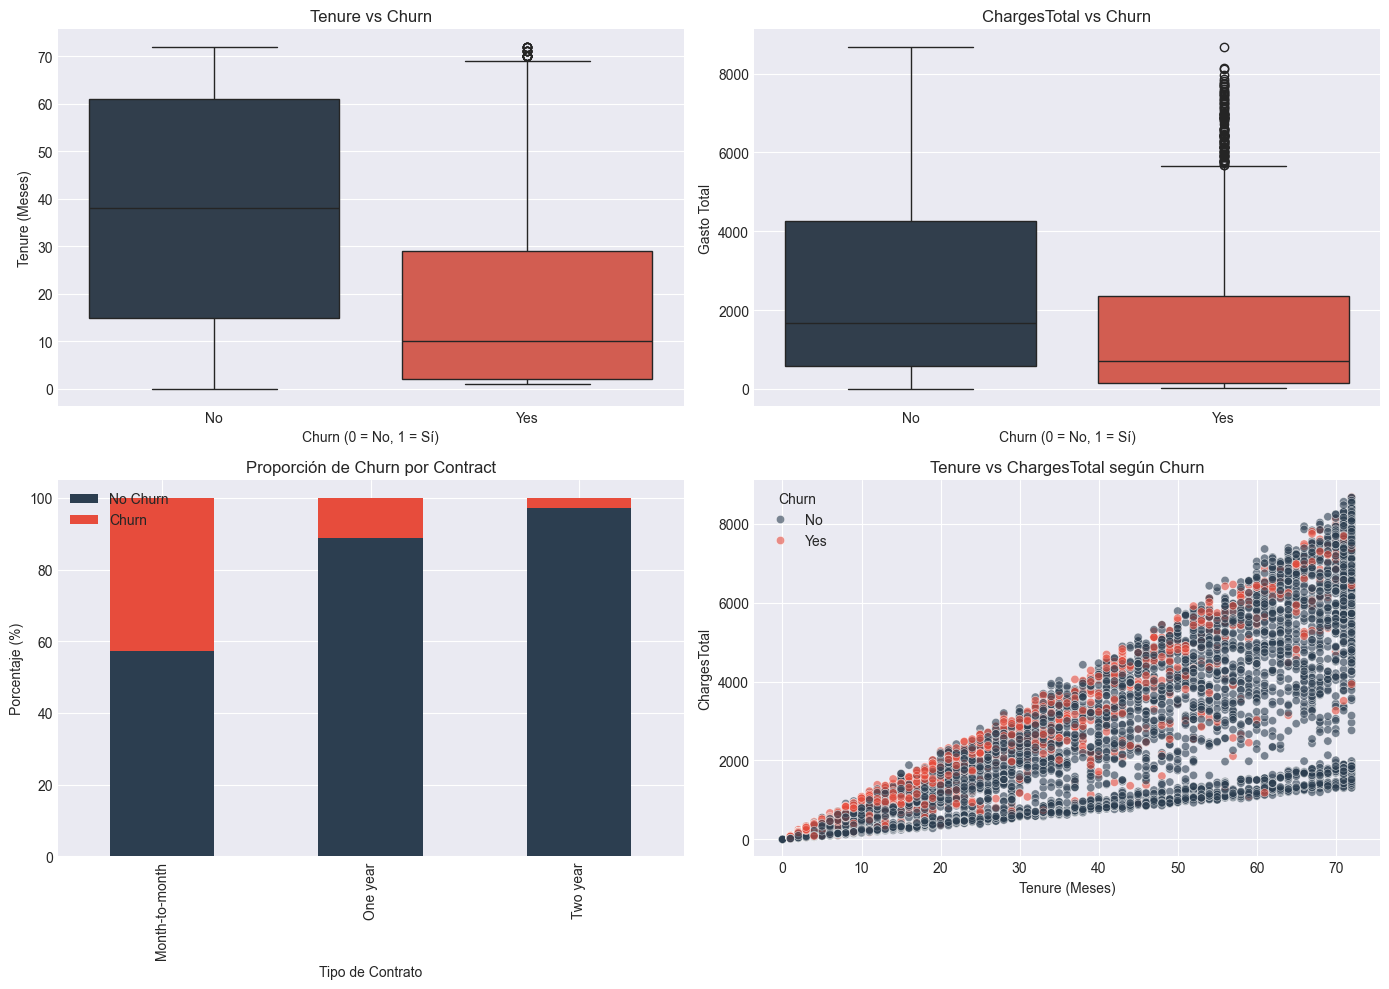

In [22]:
# ============================================================
# ANÁLISIS VISUAL INTEGRADO (2x2)  Tenure ChargesTotal Contract
# ============================================================

import os
import plotly.express as px

# Crear carpeta si no existe
os.makedirs("imgs", exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ------------------------------------------------------------
# 1 Tenure vs Churn (Boxplot)
# ------------------------------------------------------------

sns.boxplot(
    ax=axes[0, 0],
    x="Churn",
    y="Tenure",
    data=df,
    palette=[color_no_churn, color_churn]
)

axes[0, 0].set_title("Tenure vs Churn")
axes[0, 0].set_xlabel("Churn (0 = No, 1 = Sí)")
axes[0, 0].set_ylabel("Tenure (Meses)")


# ------------------------------------------------------------
# 2 ChargesTotal vs Churn (Boxplot)
# ------------------------------------------------------------

sns.boxplot(
    ax=axes[0, 1],
    x="Churn",
    y="ChargesTotal",
    data=df,
    palette=[color_no_churn, color_churn ]
)

axes[0, 1].set_title("ChargesTotal vs Churn")
axes[0, 1].set_xlabel("Churn (0 = No, 1 = Sí)")
axes[0, 1].set_ylabel("Gasto Total")


# ------------------------------------------------------------
# 3 Contract vs Churn (Proporción)
# ------------------------------------------------------------

contract_churn = pd.crosstab(
    df["Contract"],
    df["Churn"],
    normalize="index"
) * 100

contract_churn.plot(
    kind="bar",
    stacked=True,
    ax=axes[1, 0],
    color=[color_no_churn, color_churn]
)

axes[1, 0].set_title("Proporción de Churn por Contract")
axes[1, 0].set_ylabel("Porcentaje (%)")
axes[1, 0].set_xlabel("Tipo de Contrato")
axes[1, 0].legend(["No Churn", "Churn"])


# ------------------------------------------------------------
# 4 Scatter: Tenure vs ChargesTotal
# ------------------------------------------------------------

sns.scatterplot(
    ax=axes[1, 1],
    x="Tenure",
    y="ChargesTotal",
    hue="Churn",
    data=df,
    palette=[color_no_churn, color_churn],
    alpha=0.6
)

axes[1, 1].set_title("Tenure vs ChargesTotal según Churn")
axes[1, 1].set_xlabel("Tenure (Meses)")
axes[1, 1].set_ylabel("ChargesTotal")

# Ajustes finales
plt.tight_layout()

# Guardar imagen
plt.savefig("imgs/analisis_dirigido_churn.png", dpi=300, bbox_inches="tight")

plt.show()



#### Resultados del Análisis Dirigido entre Tenure, ChargesTotal y Contract vs Churn

##### 1 Tenure vs Churn
- Los clientes que cancelan (Churn = Yes) presentan una **mediana de permanencia significativamente menor**.
- La mayoría del churn ocurre en los primeros meses.
- Clientes con mayor antigüedad muestran mucha menor tasa de cancelación.

**Insight:** La permanencia es un fuerte indicador inverso de churn.

---

##### 2 ChargesTotal vs Churn
- Clientes con churn tienen un **gasto total considerablemente menor**.
- Esto se explica porque abandonan el servicio en etapas tempranas.
- Los clientes con mayor gasto acumulado tienden a permanecer.

**Insight:** El gasto total refleja indirectamente la antigüedad y estabilidad del cliente.

---

##### 3 Contract vs Churn
- El contrato *Month-to-month* presenta la **mayor proporción de churn (~43%)**.
- Contratos de *One year* reducen significativamente la cancelación.
- Contratos de *Two year* muestran una tasa mínima de churn (~3%).

**Insight:** El tipo de contrato es uno de los factores más determinantes del churn.

---

##### 4 Scatter: Tenure vs ChargesTotal
- Se observa una relación positiva clara entre Tenure y ChargesTotal.
- La mayor concentración de churn se encuentra en la zona de:
  - Baja permanencia
  - Bajo gasto acumulado
- A medida que aumenta la permanencia, disminuye visualmente la proporción de churn.

**Insight General:**  
El churn se concentra principalmente en clientes nuevos con contratos flexibles (Month-to-month).  
La estabilidad contractual y la antigüedad actúan como factores protectores frente a la cancelación.

### 4 Preprocesamiento de Datos (Data Preprocessing)

Preparación técnica de los datos para su uso en modelos de Machine Learning.

* **Codificación de Variables Categóricas**:

  * One-Hot Encoding para variables nominales (ej. `PaymentMethod`).
  * Label Encoding para la variable objetivo (`Churn`: 0 = No, 1 = Sí).

* **Escalado de Variables Numéricas**:

  * Estandarización (StandardScaler) o Normalización (MinMaxScaler).
  * Aplicado a variables como:

    * `Tenure`
    * `ChargesMonthly`
    * `ChargesTotal`
    * `num_services`
    



* **Pipeline de Preprocesamiento**:
  Implementación de `Pipeline` para evitar data leakage y garantizar reproducibilidad.

---
